### Imports & function definitions

In [1]:
from once_for_all.evaluation.perf_dataset import PerformanceDataset
from utils.config_utils import get_mfcc_params, get_mel_spectrogram_params
import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def round_to_base(num, base):
    return base * round(num / base)

def create_stats_df(data, ft_extr_type, params_id):
    # Gather initial rows
    df = None
    for k, v in data.items():
        if df is None:
            df = pd.json_normalize(v)
            df = pd.concat([pd.json_normalize(json.loads(k)), df], axis=1)
        else:
            row = pd.json_normalize(v)
            row = pd.concat([pd.json_normalize(json.loads(k)), row], axis=1)
            df = df.append(row)
                
    ks_mean = np.mean(df['ks'].tolist(), axis=1)
    df['ks_mean'] = ks_mean

    e_mean = np.mean(df['e'].tolist(), axis=1)
    df['e_mean'] = e_mean

    d_mean = np.mean(df['d'].tolist(), axis=1)
    df['d_mean'] = d_mean

    df['acc_params_ratio'] = df['top1'] / df['net_info.params']
    df['acc_flops_ratio'] = df['top1'] / df['net_info.flops']
    
    # As measure_latency was set to false
    try:
        df['gpu4lat']= df['net_info.gpu4 latency.hist.sample'].apply(lambda x: x[0][0]/x[0][1])
        df['cpulat']= df['net_info.cpu latency.hist.sample'].apply(lambda x: x[0][0]/x[0][1])
        df['acc_gpu4lat_ratio'] = df['top1'] / df['gpu4lat']
        df['acc_cpulat_ratio'] = df['top1'] / df['cpulat']
    
        df = df.drop(columns=['net_info.gpu4 latency.val', 'net_info.gpu4 latency.hist.warmup',
                          'net_info.gpu4 latency.hist.sample',
                          'net_info.cpu latency.val', 'net_info.cpu latency.hist.warmup',
                          'net_info.cpu latency.hist.sample'])
    except:
        print("Following pair has no lat eval")
        print(ft_extr_type)
        print(params_id)
        pass
    
    # Round up values for plotting
    base_params = .5
    
    df['ks_m'] = df['ks_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['d_m'] = df['d_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['e_m'] = df['e_mean'].apply(lambda x: round_to_base(num=x,base=base_params))
    df['p'] = df['net_info.params'].apply(lambda x: round_to_base(num=x,base=100))
    
    df['data_shape'] = df['data_shape'].apply(lambda x: str(x))

    return df

#### Define ft_extr_type and params_ids to analyse

In [3]:
# ft_extr_types = ["mfcc", "log_mel_spectrogram", "mel_spectrogram", "log_spectrogram", "spectrogram", "raw"]
# params_ids = [1,2,3,4,5,6,7,8]

# ft_extr_types = ["raw"]
ft_extr_types = ["mfcc", "mel_spectrogram", "raw"]
params_ids = [1,2,3,4,5,6,7,8]

#### Gather data

In [4]:
df = None
full_ft_extr_params_list = None

for f_i, ft_extr_type in enumerate(ft_extr_types):
    for p_i, params_id in enumerate(params_ids):
        try:
            if ft_extr_type == "mfcc":
                n_mfcc_bins, ft_extr_params_list = get_mfcc_params(params_id)
            elif ft_extr_type == "mel_spectrogram":
                ft_extr_params_list = get_mel_spectrogram_params(params_id)
            elif ft_extr_type == "raw":
                ft_extr_params_list = [(125, 128)] if params_id == 1 else []   
            elif ft_extr_type == "spectrogram":
                ft_extr_params_list = get_spectrogram_params(params_id)
            elif ft_extr_type == "linear_stft":
                ft_extr_params_list = get_linear_stft_params(params_id)
        except:
            continue

        
        path = "eval/" + ft_extr_type + str(params_id) + "/"
        performance_dataset = PerformanceDataset(path, use_csv=False)

        for ft_extr_params in ft_extr_params_list:
            try:
                data = performance_dataset.load_dataset(ft_extr_params)
                # print("Gathering data for %s %s" %(ft_extr_type, params_id))
                df_ft_extr_p = create_stats_df(data, ft_extr_type, params_id)
                df_ft_extr_p.loc[:, 'params_id'] = params_id
                df_ft_extr_p.loc[:, 'ft_extr_type'] = ft_extr_type
                if df is None:
                    df = df_ft_extr_p
                else:
                    df = pd.concat([df, df_ft_extr_p], axis=0)
            except:
                continue
            
        for i, ft_e_p in enumerate(ft_extr_params_list):
            if full_ft_extr_params_list is None:
                full_ft_extr_params_list = [list(ft_e_p)]   
            else:     
                if ft_e_p not in full_ft_extr_params_list:
                    full_ft_extr_params_list.append(list(ft_e_p))

        
full_shape_list = list(df['data_shape'].unique())        
print("full ft extr params list : ", full_ft_extr_params_list) 
print("full shape list : ", full_shape_list) 

# Convert ft_extr_params to id for plotting
df = df.loc[:,~df.columns.duplicated()] # Remove duplicates
df["ft_extr_id"] = df["ft_extr_params"].apply(lambda x: full_ft_extr_params_list.index(x))
df["shape_id"] = df['data_shape'].apply(lambda x: full_shape_list.index(x))

def name_ft_extr(fttype, paramid, params):
    return fttype + str(paramid) + "_" + str(tuple(params))

def extract_pi(params, i):
    return params[i]
    
df['ft_extr'] = df.apply(lambda x: name_ft_extr(x.ft_extr_type, x.params_id, x.ft_extr_params), axis=1)

df['ft_extr_p0'] = df.apply(lambda x: extract_pi(x.ft_extr_params,0), axis=1)
df['ft_extr_p1'] = df.apply(lambda x: extract_pi(x.ft_extr_params,1), axis=1)

def get_mfcc_bins(ft_extr_type, params_id):
    if ft_extr_type == "mfcc":
        if params_id == 7:
            return 80
        elif params_id < 5: # 1, 2, 3, 4
            return 10
        else: # 5, 6, 8
            return 40
    else:
        return 0

df['mfcc_bins'] = df.apply(lambda x: get_mfcc_bins(x.ft_extr_type,x.params_id), axis=1)
df['net_info.flops'] = df['net_info.flops'] / 1e6
df['net_info.params'] = df['net_info.params'] / 1e3

df.columns

full ft extr params list :  [[40, 40], [10, 30], [10, 40], [10, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [80, 30], [80, 40], [80, 50], [40, 40], [10, 20], [10, 25], [10, 30], [40, 20], [40, 30], [40, 40], [80, 20], [80, 30], [80, 40], [125, 128]]
full shape list :  ['[1, 51, 10]', '[1, 67, 10]', '[1, 41, 10]', '[1, 67, 40]', '[1, 51, 40]', '[1, 41, 40]', '[1, 67, 80]', '[1, 51, 80]', '[1, 41, 80]', '[1, 101, 10]', '[1, 81, 10]', '[1, 101, 40]', '[1, 101, 80]', '[1, 125, 128]']


Index(['w', 'ks', 'd', 'e', 'ft_extr_params', 'data_shape', 'top1',
       'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean', 'd_mean',
       'acc_params_ratio', 'acc_flops_ratio', 'gpu4lat', 'cpulat',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio', 'ks_m', 'd_m', 'e_m', 'p',
       'params_id', 'ft_extr_type', 'ft_extr_id', 'shape_id', 'ft_extr',
       'ft_extr_p0', 'ft_extr_p1', 'mfcc_bins'],
      dtype='object')

In [5]:
df

w                                                ks  \
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 7, 5]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 5, 7, 5, 7, 7, 5, 3, 5, 7]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 7, 5, 5, 5, 7, 5, 3, 5, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 7, 3, 5, 5, 3, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 5, 5, 5, 7, 3, 5, 3, 5]   
..              ...                                               ...   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 3, 5, 3, 5, 7, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 3, 3, 5, 7, 7, 3, 7, 5, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 5, 7, 5, 7, 5, 5, 3, 3, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 3, 3, 5, 3, 7, 3]   

               d                                                 e  \
0   [3, 4, 1, 4]  [1, 3, 3, 1, 2, 3, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3]   
0   [1, 3, 2, 3]  [2, 1, 1, 2, 1, 2, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1]   
0   [4, 1, 2, 1]  [1, 1, 2, 2, 3, 1, 2, 3, 1, 2, 3, 3, 3, 3, 1, 2]   
0   [3, 2, 2, 4]  [3, 3, 2, 2, 2, 3, 3, 3, 1, 2, 3, 2, 3, 2, 1, 1]   
0   [3, 1, 2, 4]  [3, 3, 3, 3, 1, 2, 2, 3, 3, 2, 3, 2, 1, 2, 2, 3]   
..           ...                                               ...   
0   [2, 1, 4, 2]  [3, 2, 2, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 2, 2]   
0   [2, 4, 2, 1]  [3, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2]   
0   [3, 3, 4, 4]  [1, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 3]   
0   [3, 3, 2, 1]  [1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 3, 2, 3, 1]   
0   [2, 4, 4, 3]  [1, 1, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 3, 1, 3, 2]   

   ft_extr_params     data_shape       top1  net_info.params  net_info.flops  \
0        [40, 40]    [1, 51, 10]  89.972775          242.572       12.158080   
0        [40, 40]    [1, 51, 10]  88.770416          162.508        5.018240   
0        [40, 40]    [1, 51, 10]  89.042653          131.724        8.513216   
0        [40, 40]    [1, 51, 10]  89.019966          203.276       12.241728   
0        [40, 40]    [1, 51, 10]  88.611616          212.492       11.718848   
..            ...            ...        ...              ...             ...   
0      [125, 128]  [1, 125, 128]  80.580762          225.292      331.416320   
0      [125, 128]  [1, 125, 128]  80.376588          158.156      301.662976   
0      [125, 128]  [1, 125, 128]  82.577133          266.636      378.880768   
0      [125, 128]  [1, 125, 128]  80.739565          101.708      125.715200   
0      [125, 128]  [1, 125, 128]  81.034483          264.972      203.133696   

    ks_mean  ...  e_m       p  params_id  ft_extr_type  ft_extr_id  shape_id  \
0     3.875  ...  2.0  242600          1          mfcc           0         0   
0     4.500  ...  2.0  162500          1          mfcc           0         0   
0     4.125  ...  2.0  131700          1          mfcc           0         0   
0     3.625  ...  2.0  203300          1          mfcc           0         0   
0     4.000  ...  2.5  212500          1          mfcc           0         0   
..      ...  ...  ...     ...        ...           ...         ...       ...   
0     4.625  ...  2.0  225300          1           raw          29        13   
0     5.625  ...  2.0  158200          1           raw          29        13   
0     5.625  ...  2.0  266600          1           raw          29        13   
0     5.625  ...  1.5  101700          1           raw          29        13   
0     5.625  ...  2.0  265000          1           raw          29        13   

            ft_extr  ft_extr_p0  ft_extr_p1  mfcc_bins  
0    mfcc1_(40, 40)          40          40         10  
0    mfcc1_(40, 40)          40          40         10  
0    mfcc1_(40, 40)          40          40         10  
0    mfcc1_(40, 40)          40          40         10  
0    mfcc1_(40, 40)          40          40         10  
..              ...         ...     

### Global plots, overall stats

#### Utility functions

In [6]:
def filter_ft_type_param_id(df, keep_ft_extr_type_list, keep_params_id_list, keep_ft_extr_id_list):
    filter_cond = 0
    for p in keep_ft_extr_type_list:
        filter_cond = filter_cond | (df["ft_extr_type"] == p)
        
    temp_df = df.loc[filter_cond]

    
    filter_cond = 0
    for p in keep_params_id_list:
        filter_cond = filter_cond | (temp_df["params_id"] == p)

    temp_df = temp_df.loc[filter_cond]
    
    filter_cond = 0
    for p in keep_ft_extr_id_list:
        filter_cond = filter_cond | (temp_df["ft_extr_id"] == p)

    temp_df = temp_df.loc[filter_cond]

    return temp_df

def filter_ft_extr_type(df, keep_ft_extr_type_list):
    filter_cond = 0
    for p in keep_ft_extr_type_list:
        filter_cond = filter_cond | (df["ft_extr_type"] == p)
        
    return df.loc[filter_cond]


def remove_worse(_df, x, y, col, base):
    df = _df.copy()
    x_col = "rnd_" + x
    df[x_col] = df[x].apply(lambda val: round_to_base(num=val, base=base)) # build col with rounded val
    
    max_df = df.groupby([x_col,col]).max().reset_index() # For all same rounded x values, remove non max y
    return max_df

In [7]:
ft_extr_full_id_list = list(df['ft_extr'].unique())
temp_df = df.copy()

params_id # params_id 
shape_id # data_shape
ft_extr_id # ft_extr_params 
ft_extr # combination of the 3 above

### Plot 1: Full training after PS, compare ft_extr_types full results (acc/flops), (acc/params)

Note we filter out worse networks by taking the max for each bins (otherwise we would have a cluster with all acc ranges).
Flops are in M.
Params are in M.

In [8]:
height = 3
aspect = 5/3

##### Accuracy to flops

In [9]:
def plot_distribution(y, hue, data):   
    dis = sns.displot(x=y, hue=hue, col=col, data=data, kind="kde",palette="bright", height=height, aspect=aspect)
    fig = dis.fig 
    fig.suptitle("%s distribution, by %s" % (y, hue), fontsize=12)

In [10]:
def plot_top(x, y, hue, col, df, keep_threshold, base):
    top_df = remove_worse(df, x, y, hue, base)
    if keep_threshold is not None:
        top_df = top_df[top_df[x] < keep_threshold]

    lm = sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=False, order=2, height=height, aspect=aspect)
    fig = lm.fig 
    fig.suptitle("%s to %s, by %s" % (x, y, hue), fontsize=12)
    

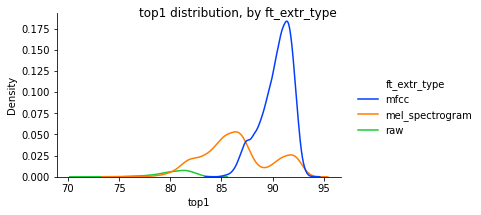

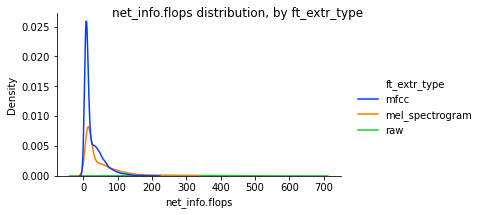

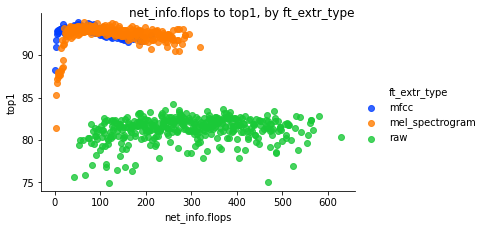

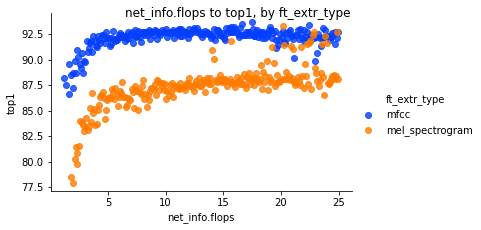

In [11]:
x = 'net_info.flops'
keep_threshold = None # 100 # .3e8 #None
y = 'top1'
hue = 'ft_extr_type' # 'shape_id'
col = None
flops_base = 1

temp_df = df.copy()
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 25 # .3e8 #None
flops_base = 1e-1
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### Accuracy to params

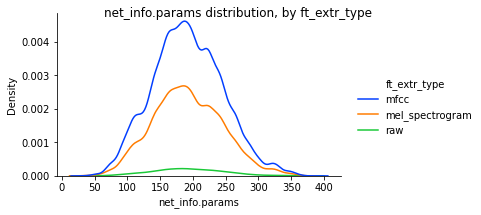

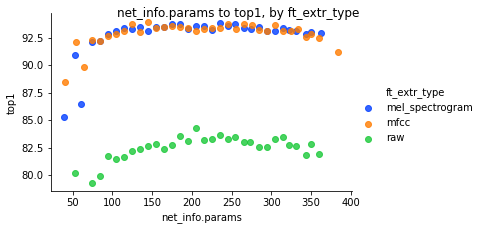

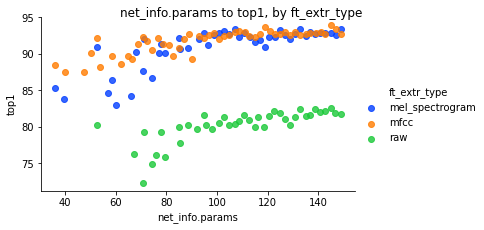

In [12]:
x = 'net_info.params'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_type' # 'shape_id'
col = None
params_base = 10

temp_df = df.copy()
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, params_base)

keep_threshold = 150 # .3e8 #None
params_base = 2

plot_top(x, y, hue, col, temp_df, keep_threshold, params_base)

### MFCC Analysis per ft_extr_params (n_mfcc_bins, n_mels, win_len)

##### n_mfcc bins

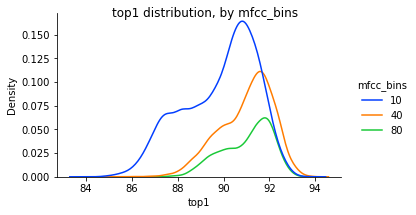

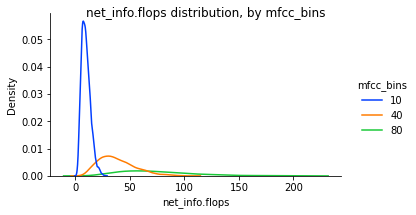

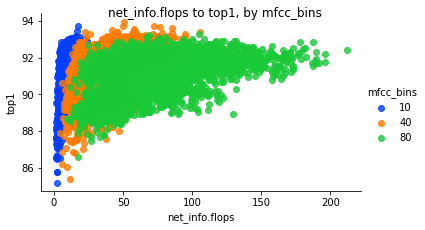

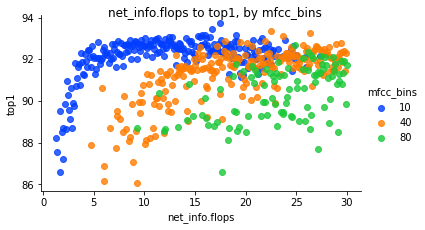

In [13]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'mfcc_bins' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = .01

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 1e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### n_mels

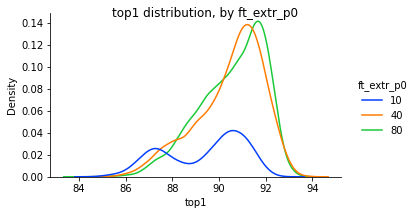

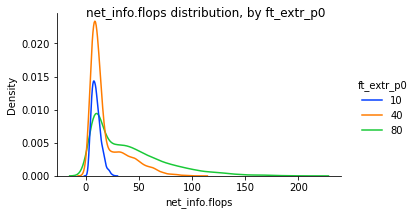

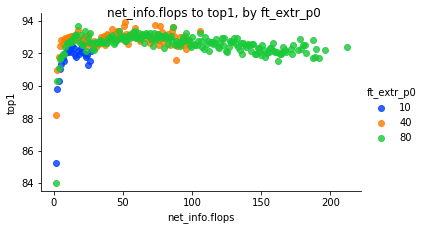

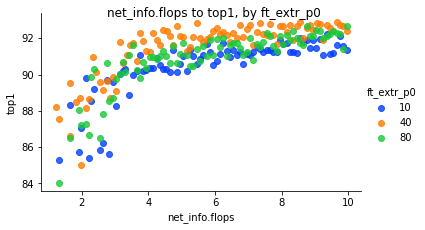

In [14]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p0' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']

plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 10 # .3e8 #None
flops_base = .1
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

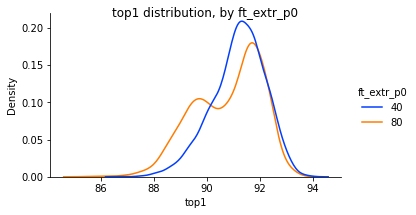

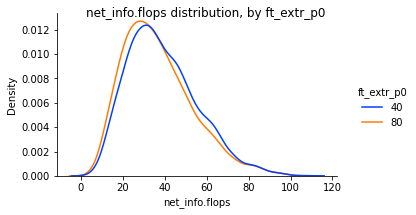

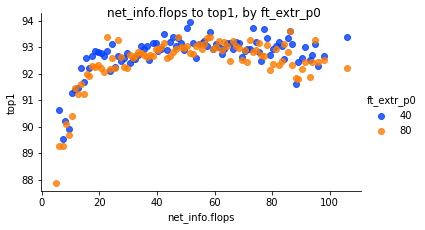

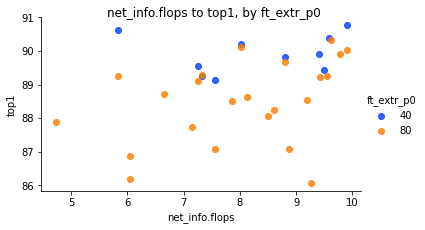

In [15]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p0' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']
temp_df = temp_df.loc[temp_df["mfcc_bins"] == 40]

plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 10 # .3e8 #None
flops_base = .1
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

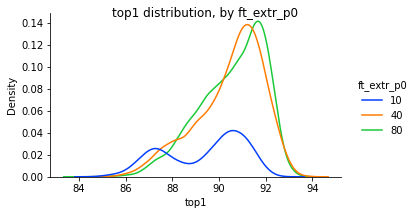

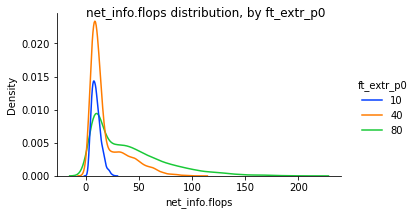

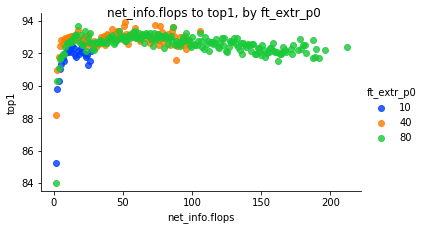

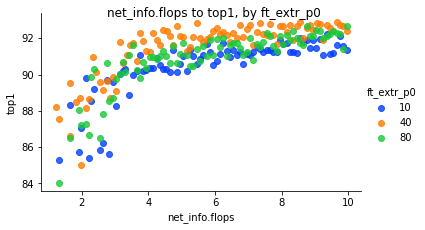

In [16]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p0' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 10 # .3e8 #None
flops_base = .1
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### Win length

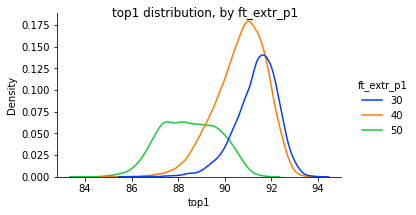

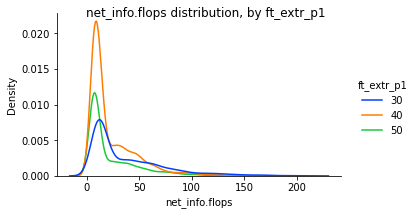

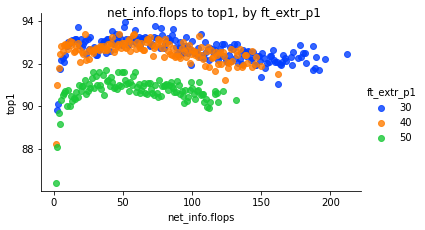

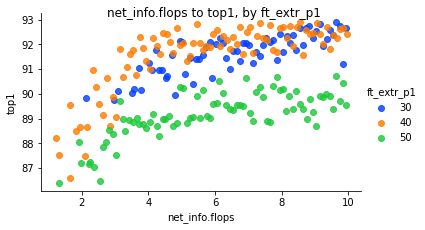

In [17]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p1' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 10 # .3e8 #None
flops_base = .1
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### ALL 3

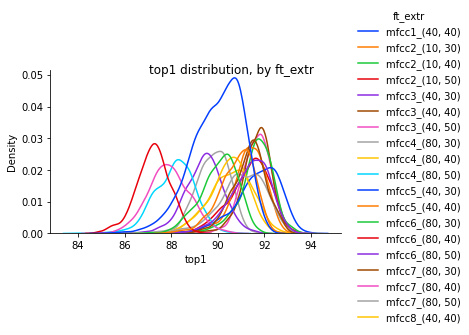

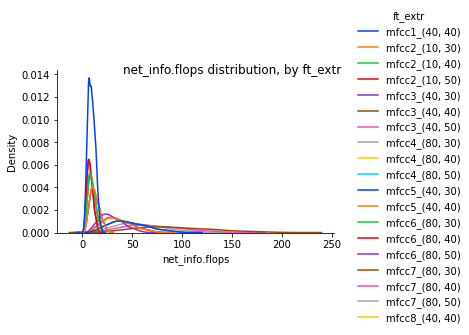

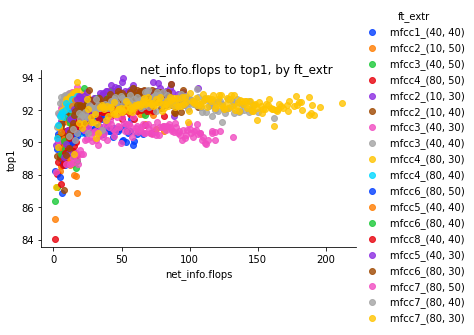

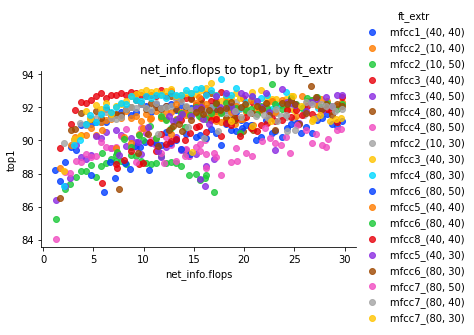

In [18]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mfcc']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 5e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

### MelSpectrogram evaluation

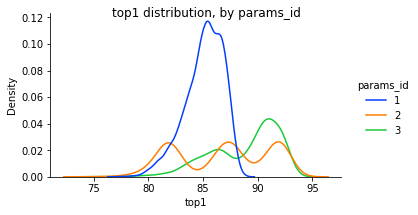

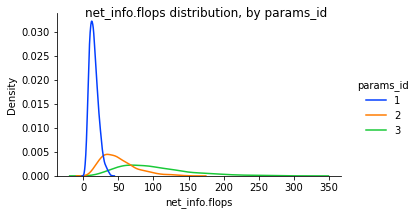

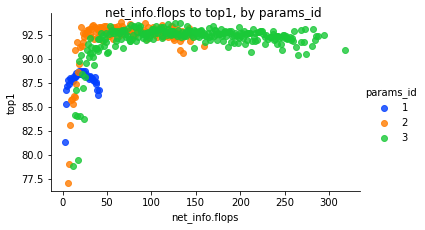

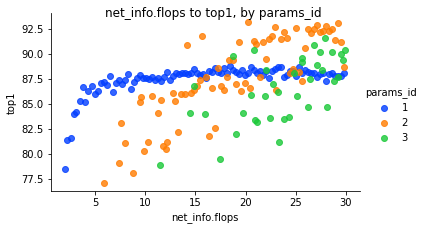

In [19]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'params_id' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mel_spectrogram']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 3e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### n_mels

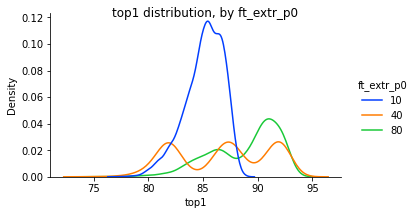

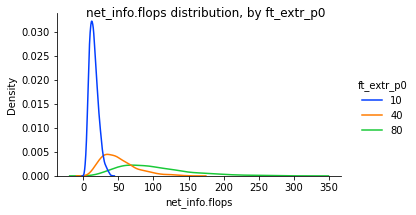

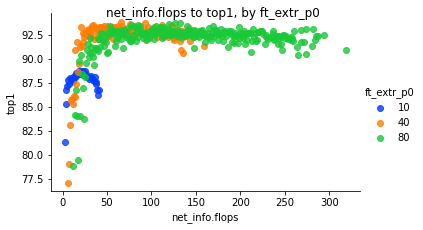

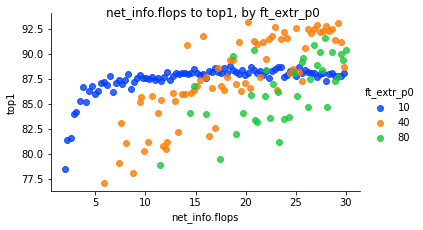

In [20]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p0' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mel_spectrogram']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 3e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### win_len

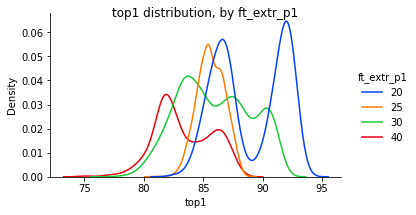

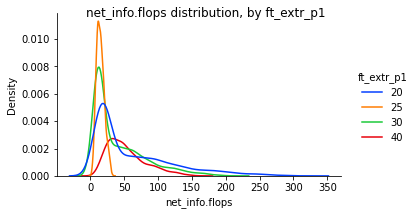

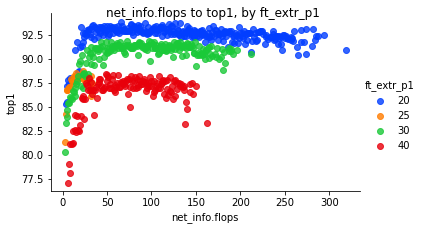

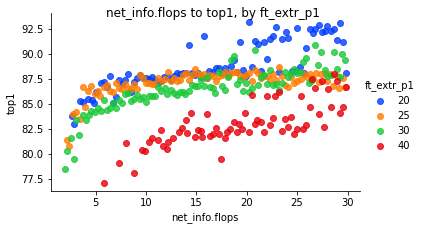

In [21]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p1' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mel_spectrogram']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 3e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

##### Both

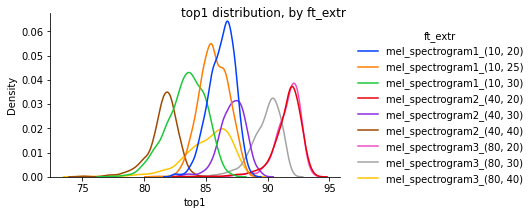

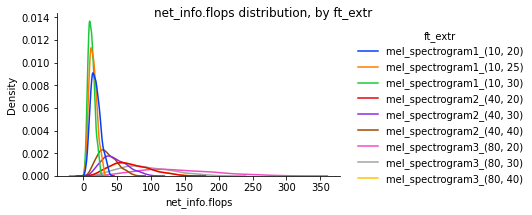

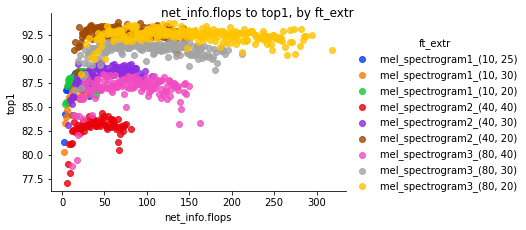

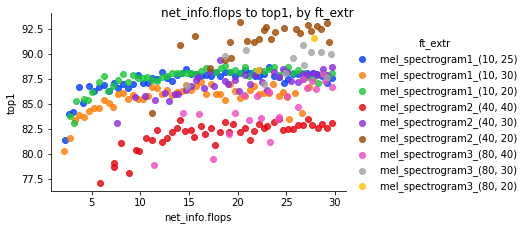

In [22]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1

temp_df = df.loc[df["ft_extr_type"] == 'mel_spectrogram']
plot_distribution(y, hue, temp_df)
plot_distribution(x, hue, temp_df)
plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

keep_threshold = 30 # .3e8 #None
flops_base = 5e-1

plot_top(x, y, hue, col, temp_df, keep_threshold, flops_base)

In [ ]:
# TODO clean below

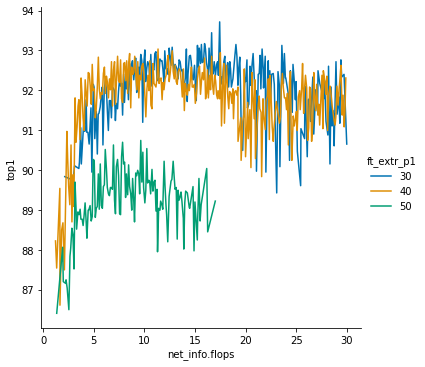

In [106]:
x = 'net_info.flops'
keep_threshold = 30 # .3e8 #None
y = 'top1'
hue = 'ft_extr_p1' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 100000

top_df = remove_worse(temp_df, x, y, hue, flops_base)
top_df = top_df.loc[top_df["ft_extr_type"] == 'mfcc']
top_df['net_info.flops'] = top_df['net_info.flops'] / 1e6


if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
    
sns.relplot(x=x, y=y, hue=hue, col=col, data=top_df, kind="line", palette="colorblind")

# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df, palette="bright", scatter=True, fit_reg=True,height=height, aspect=aspect);
    
# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=False, order=2, height=height, aspect=aspect);

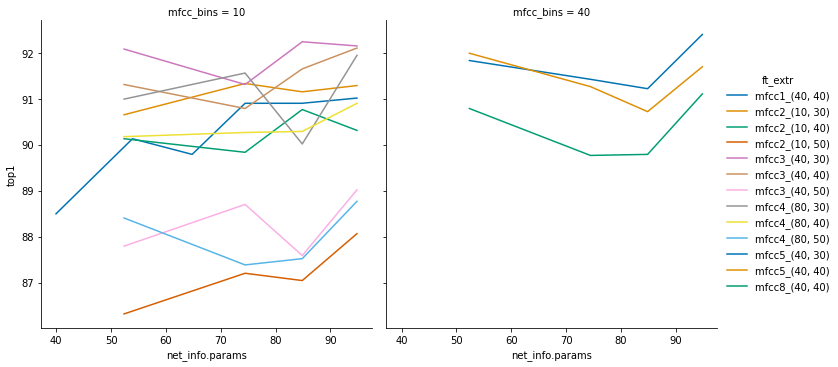

In [89]:
x = 'net_info.params'
keep_threshold = 100 # .3e8 #None
y = 'top1'
hue = 'ft_extr' # 'shape_id'
col = "mfcc_bins" # 'ft_extr_type'
params_base = 10000

top_df = remove_worse(temp_df, x, y, hue, params_base)
top_df = top_df.loc[top_df["ft_extr_type"] == 'mfcc']
top_df['net_info.params'] = top_df['net_info.params'] / 1e3


if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
    
sns.relplot(x=x, y=y, hue=hue, col=col, data=top_df, kind="line", palette="colorblind")

# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df, palette="bright", scatter=True, fit_reg=True,height=height, aspect=aspect);
    
# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=False, order=2, height=height, aspect=aspect);

### Accuracy distribution for each ft_extr_type

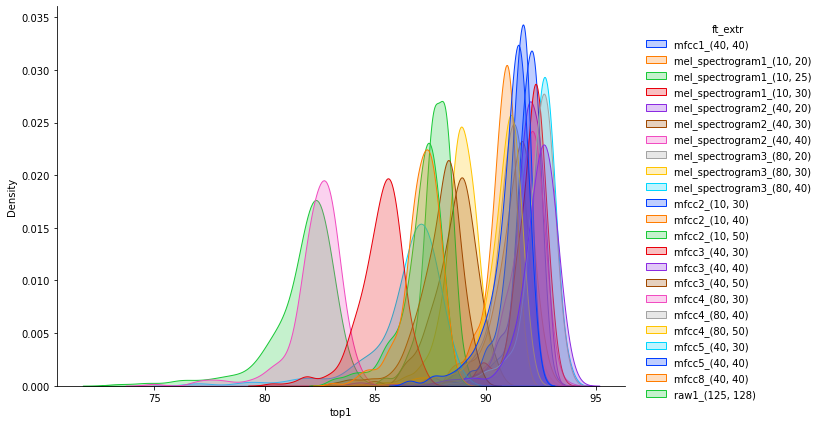

In [31]:
height = 6
aspect = 9/6

x = 'net_info.params'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr' # 'shape_id'
col =  None # 'ft_extr_type'
params_base = 1000

top_df = remove_worse(temp_df, x, y, hue, params_base)
top_df['net_info.params'] = top_df['net_info.params'] / 1e3

if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
sns.displot(x=y, hue=hue, col=col, data=top_df ,palette="bright", height=height, aspect=aspect, kind="kde", fill=True) # kind="ecdf"

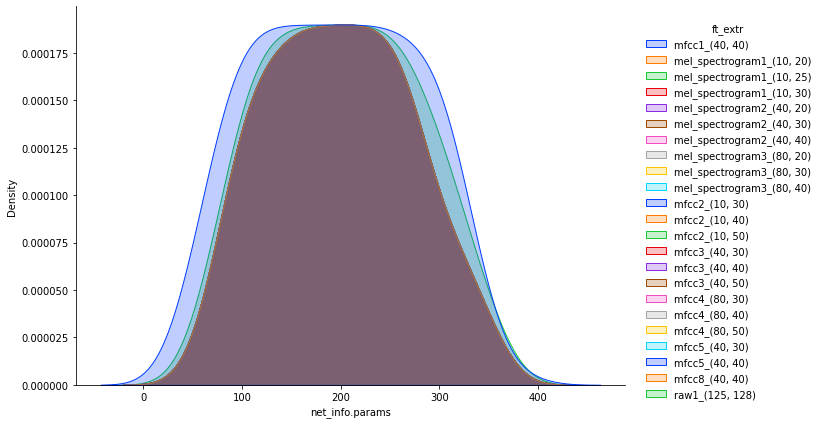

In [32]:
height = 6
aspect = 9/6

x = 'net_info.params'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr' # 'shape_id'
col =  None # 'ft_extr_type'
params_base = 1000

top_df = remove_worse(temp_df, x, y, hue, params_base)
top_df['net_info.params'] = top_df['net_info.params'] / 1e3

if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
sns.displot(x=x, hue=hue, col=col, data=top_df ,palette="bright", height=height, aspect=aspect, kind="kde", fill=True) # kind="ecdf"

In [33]:
x = 'net_info.flops'
keep_threshold = .3e8 #None

y = 'top1'
hue = 'ft_extr' # 'shape_id'
col = None


height = 7
aspect = 9/7
print(full_shape_list)

flops_base = 1000000
params_base = 2000
base = flops_base if x == 'net_info.flops' else params_base if x == 'net_info.params' else oth_base


['[1, 51, 10]', '[1, 67, 10]', '[1, 41, 10]', '[1, 67, 40]', '[1, 51, 40]', '[1, 101, 10]', '[1, 81, 10]', '[1, 101, 40]', '[1, 101, 80]', '[1, 67, 80]', '[1, 51, 80]', '[1, 125, 128]']


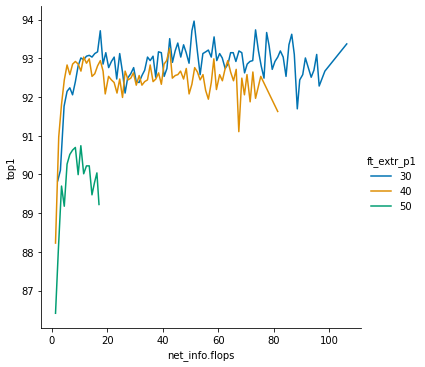

In [104]:
x = 'net_info.flops'
keep_threshold = None # .3e8 #None
y = 'top1'
hue = 'ft_extr_p1' # 'ft_extr' 
col = None # "mfcc_bins" 
flops_base = 1000000

top_df = remove_worse(temp_df, x, y, hue, flops_base)
top_df = top_df.loc[top_df["ft_extr_type"] == 'mfcc']
top_df['net_info.flops'] = top_df['net_info.flops'] / 1e6


if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
    
sns.relplot(x=x, y=y, hue=hue, col=col, data=top_df, kind="line", palette="colorblind")

# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df, palette="bright", scatter=True, fit_reg=True,height=height, aspect=aspect);
    
# sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=False, order=2, height=height, aspect=aspect);

/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:256: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Pol

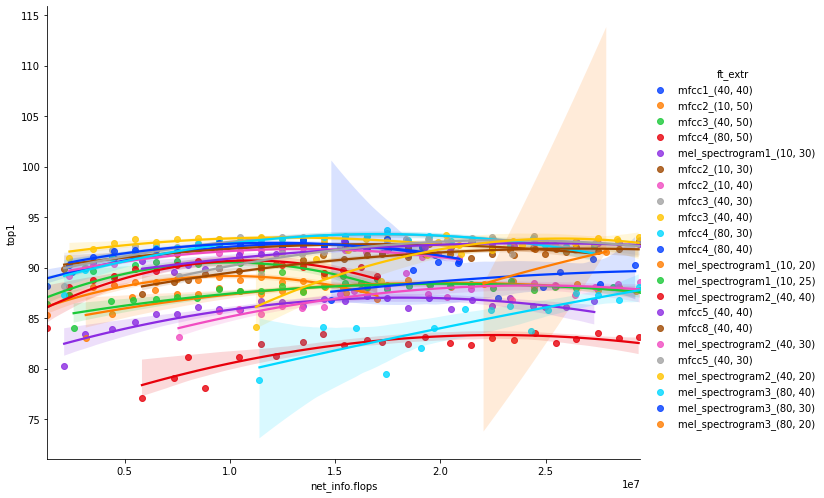

In [35]:
top_df = remove_worse(temp_df, x, y, hue, base)
if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=True, order = 2, height=height, aspect=aspect);

# IN PROGRESS

In [39]:
keep_ft_extr_id_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
keep_ft_extr_type_list = ["mfcc", "mel_spectrogram", "spectrogram", "linear_stft", "raw"]
keep_params_id_list = [1,2,3,4,5,7,8]

# base parameters for display bins
flops_base = 1000000
params_base = 10000
ks_base = .25
d_base = .25
e_base = .1
oth_base = .5


In [40]:
keep_ft_extr_type_list = ["mfcc"]

mfcc_df = filter_ft_type_param_id(df, keep_ft_extr_type_list, keep_params_id_list, keep_ft_extr_id_list)
mfcc_df

w                                                ks  \
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 7, 5]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 5, 7, 5, 7, 7, 5, 3, 5, 7]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 3, 7, 5, 5, 5, 7, 5, 3, 5, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 7, 3, 5, 5, 3, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 3, 5, 3, 5, 5, 5, 7, 3, 5, 3, 5]   
..              ...                                               ...   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 3, 5, 3, 5, 7, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 3, 3, 5, 7, 7, 3, 7, 5, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 5, 7, 5, 7, 5, 5, 3, 3, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 3, 3, 5, 3, 7, 3]   

               d                                                 e  \
0   [3, 4, 1, 4]  [1, 3, 3, 1, 2, 3, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3]   
0   [1, 3, 2, 3]  [2, 1, 1, 2, 1, 2, 3, 1, 1, 3, 3, 1, 3, 2, 1, 1]   
0   [4, 1, 2, 1]  [1, 1, 2, 2, 3, 1, 2, 3, 1, 2, 3, 3, 3, 3, 1, 2]   
0   [3, 2, 2, 4]  [3, 3, 2, 2, 2, 3, 3, 3, 1, 2, 3, 2, 3, 2, 1, 1]   
0   [3, 1, 2, 4]  [3, 3, 3, 3, 1, 2, 2, 3, 3, 2, 3, 2, 1, 2, 2, 3]   
..           ...                                               ...   
0   [2, 1, 4, 2]  [3, 2, 2, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 2, 2]   
0   [2, 4, 2, 1]  [3, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2]   
0   [3, 3, 4, 4]  [1, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 3]   
0   [3, 3, 2, 1]  [1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 3, 2, 3, 1]   
0   [2, 4, 4, 3]  [1, 1, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 3, 1, 3, 2]   

   ft_extr_params   data_shape       top1  net_info.params  net_info.flops  \
0        [40, 40]  [1, 51, 10]  89.972775           242572      12158080.0   
0        [40, 40]  [1, 51, 10]  88.770416           162508       5018240.0   
0        [40, 40]  [1, 51, 10]  89.042653           131724       8513216.0   
0        [40, 40]  [1, 51, 10]  89.019966           203276      12241728.0   
0        [40, 40]  [1, 51, 10]  88.611616           212492      11718848.0   
..            ...          ...        ...              ...             ...   
0        [10, 50]  [1, 41, 10]  87.454632           225292       9305280.0   
0        [10, 50]  [1, 41, 10]  87.409260           158156       8409024.0   
0        [10, 50]  [1, 41, 10]  87.817603           266636      10677888.0   
0        [10, 50]  [1, 41, 10]  87.091654           101708       3645888.0   
0        [10, 50]  [1, 41, 10]  86.819418           264972       6389760.0   

    ks_mean  ...  acc_cpulat_ratio  ks_m  d_m  e_m       p  params_id  \
0     3.875  ...         11.462609   4.0  3.0  2.0  242600          1   
0     4.500  ...         17.418138   4.5  2.0  2.0  162500          1   
0     4.125  ...         19.076493   4.0  2.0  2.0  131700          1   
0     3.625  ...         12.552928   3.5  3.0  2.0  203300          1   
0     4.000  ...         14.491804   4.0  2.5  2.5  212500          1   
..      ...  ...               ...   ...  ...  ...     ...        ...   
0     4.625  ...         21.774903   4.5  2.0  2.0  225300          2   
0     5.625  ...         25.288917   5.5  2.0  2.0  158200          2   
0     5.625  ...         16.094281   5.5  3.5  2.0  266600          2   
0     5.625  ...         27.721492   5.5  2.0  1.5  101700          2   
0     5.625  ...         17.327875   5.5  3.0  2.0  265000          2   

    ft_extr_type  ft_extr_id  shape_id         ft_extr  
0           mfcc           0         0  mfcc1_(40, 40)  
0           mfcc           0         0  mfcc1_(40, 40)  
0           mfcc           0         0  mfcc1_(40, 40)  
0           mfcc           0         0  mfcc1_(40, 40)  
0           mfcc           0         0  mfcc1_(40, 40)  
..           ...         ...       ...             ...  
0           mfcc           3         2  mfcc2_(10, 50)  
0           mfcc           3  

In [41]:
keep_ft_extr_type_list = ["mel_spectrogram"]

mel_df = filter_ft_type_param_id(df, keep_ft_extr_type_list, keep_params_id_list, keep_ft_extr_id_list)
mel_df

w                                                ks  \
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 5, 3, 3, 5, 5, 3, 7, 3, 7, 5, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 3, 7, 7, 3, 5, 3, 3, 5, 3, 7, 7, 7]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 5, 3, 5, 3, 5, 5, 3, 5, 7, 7, 7, 5]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 5, 7, 3, 7, 5, 5, 3, 7, 3, 3, 3, 3]   
0   [0, 0, 0, 0, 0]  [3, 3, 3, 3, 5, 7, 5, 7, 3, 5, 5, 3, 7, 7, 5, 5]   
..              ...                                               ...   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 3, 5, 3, 3, 3, 3, 3, 3, 3]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 5, 5, 7, 7, 5, 5, 3, 5, 3, 5, 7, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 3, 3, 5, 7, 7, 3, 7, 5, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 5, 7, 5, 7, 5, 5, 3, 3, 5, 5, 5]   
0   [0, 0, 0, 0, 0]  [7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 3, 3, 5, 3, 7, 3]   

               d                                                 e  \
0   [1, 1, 2, 3]  [1, 2, 2, 2, 2, 3, 3, 3, 1, 1, 3, 2, 1, 1, 3, 1]   
0   [4, 2, 1, 3]  [2, 1, 3, 3, 2, 3, 2, 2, 2, 1, 1, 1, 3, 2, 3, 2]   
0   [4, 3, 4, 1]  [3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 1, 2, 2, 3, 3, 2]   
0   [2, 1, 1, 3]  [2, 2, 3, 2, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 1]   
0   [4, 4, 4, 2]  [1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1]   
..           ...                                               ...   
0   [2, 1, 4, 2]  [3, 2, 2, 1, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 2, 2]   
0   [2, 4, 2, 1]  [3, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2]   
0   [3, 3, 4, 4]  [1, 3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 3]   
0   [3, 3, 2, 1]  [1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 3, 2, 3, 1]   
0   [2, 4, 4, 3]  [1, 1, 3, 3, 2, 3, 1, 3, 1, 2, 3, 3, 3, 1, 3, 2]   

   ft_extr_params    data_shape       top1  net_info.params  net_info.flops  \
0        [10, 20]  [1, 101, 10]  84.664250            79564       4595072.0   
0        [10, 20]  [1, 101, 10]  84.981851           238028      26296640.0   
0        [10, 20]  [1, 101, 10]  84.936482           265036      31809856.0   
0        [10, 20]  [1, 101, 10]  86.002726           162316      15476288.0   
0        [10, 20]  [1, 101, 10]  86.093466           250636      21675456.0   
..            ...           ...        ...              ...             ...   
0        [40, 40]   [1, 51, 40]  81.578949           225292      42979584.0   
0        [40, 40]   [1, 51, 40]  81.578949           158156      38839232.0   
0        [40, 40]   [1, 51, 40]  81.374777           266636      49109568.0   
0        [40, 40]   [1, 51, 40]  80.989114           101708      16272320.0   
0        [40, 40]   [1, 51, 40]  81.374777           264972      26426176.0   

    ks_mean  ...  acc_cpulat_ratio  ks_m  d_m  e_m       p  params_id  \
0     4.000  ...         25.205494   4.0  2.0  2.0   79600          1   
0     4.500  ...          8.769303   4.5  2.5  2.0  238000          1   
0     4.500  ...          6.639396   4.5  3.0  2.5  265000          1   
0     4.125  ...         15.605992   4.0  2.0  2.0  162300          1   
0     4.750  ...          8.927102   5.0  3.5  2.0  250600          1   
..      ...  ...               ...   ...  ...  ...     ...        ...   
0     4.625  ...          7.344040   4.5  2.0  2.0  225300          2   
0     5.625  ...          8.470820   5.5  2.0  2.0  158200          2   
0     5.625  ...          5.905967   5.5  3.5  2.0  266600          2   
0     5.625  ...          8.769574   5.5  2.0  1.5  101700          2   
0     5.625  ...          5.015069   5.5  3.0  2.0  265000          2   

       ft_extr_type  ft_extr_id  shape_id                    ft_extr  
0   mel_spectrogram           4         3  mel_spectrogram1_(10, 20)  
0   mel_spectrogram           4         3  mel_spectrogram1_(10, 20)  
0   mel_spectrogram           4         3  mel_spectrogram1_(10, 20)  
0   mel_spectrogram           4         3  mel_spectrogram1_(10, 20)  
0   mel_spectrogram           4         3  mel_spectrogram1_(10, 20)  
..              ...         ...       ...       

In [66]:
x = 'net_info.flops'
keep_threshold = .3e8 #None

y = 'top1'
hue = 'ft_extr' # 'shape_id'
col = None


height = 7
aspect = 9/7
print(full_shape_list)

flops_base = 1000000
params_base = 2000
base = flops_base if x == 'net_info.flops' else params_base if x == 'net_info.params' else oth_base


['[1, 51, 10]', '[1, 67, 10]', '[1, 41, 10]', '[1, 101, 10]', '[1, 81, 10]', '[1, 101, 40]', '[1, 67, 40]', '[1, 51, 40]']


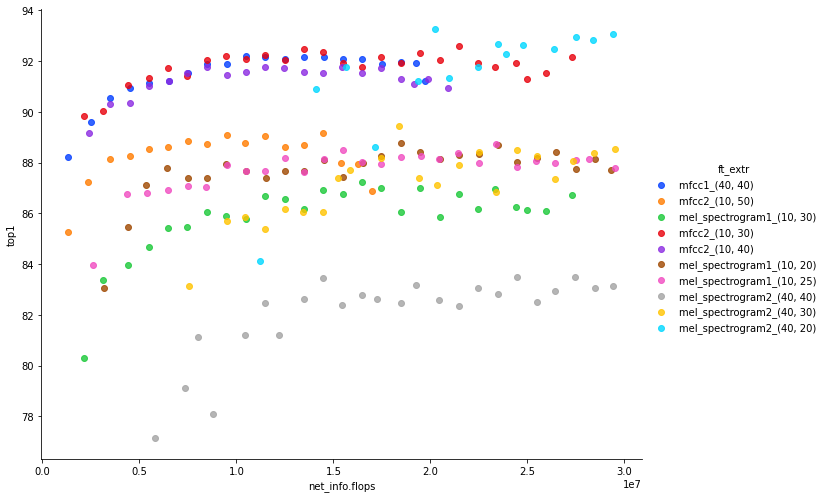

In [67]:
top_df = remove_worse(temp_df, x, y, hue, base)
if keep_threshold is not None:
    top_df = top_df[top_df[x] < keep_threshold]
sns.lmplot(x=x, y=y, hue=hue, col=col, data=top_df ,palette="bright", scatter=True, fit_reg=False, order = 2, height=height, aspect=aspect);

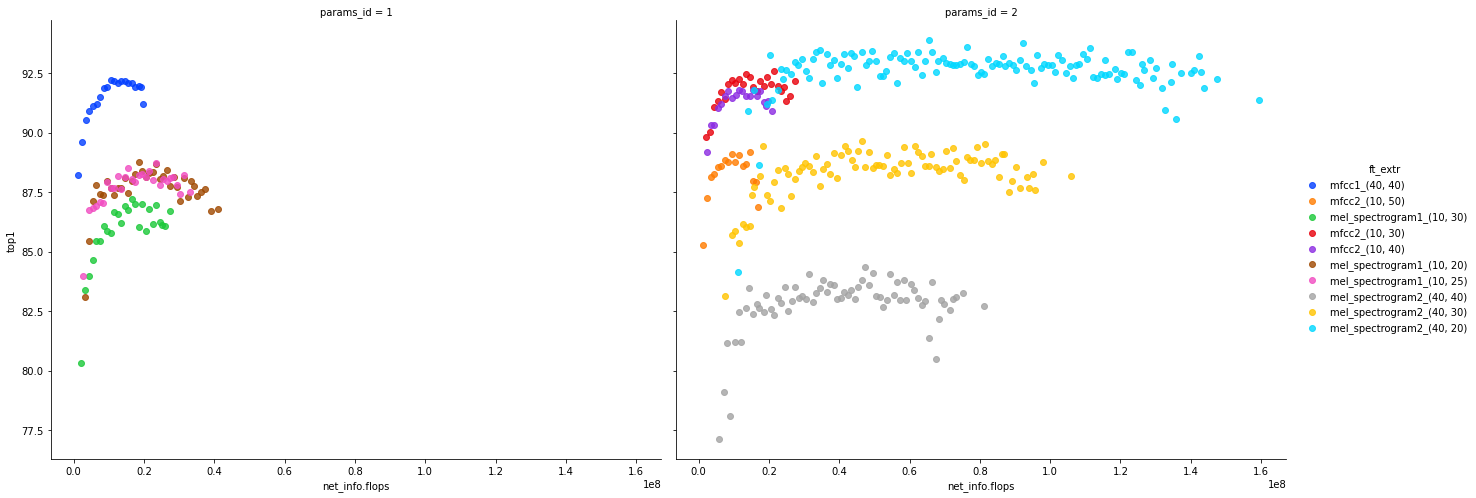

In [47]:
top_df = remove_worse(temp_df, x, y, hue, base)
sns.lmplot(x=x, y=y, hue=hue, col="params_id", data=top_df ,palette="bright", scatter=True, fit_reg=False, order = 2, height=height, aspect=aspect);

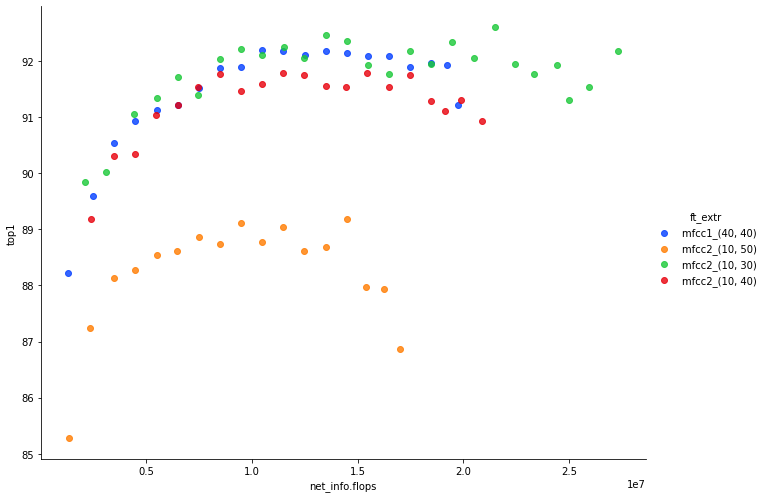

In [30]:
top_mfcc_df = remove_worse(mfcc_df, x, y, hue, base)
# top_mfcc_df = top_mfcc_df[top_mfcc_df[x] < 3e7]
# sns.scatterplot(x=x, y=y, hue=hue, data=mfcc_df, palette="bright")
sns.lmplot(x=x, y=y, hue=hue, data=top_mfcc_df ,palette="bright", scatter=True, fit_reg=False, order = 2, height=height, aspect=aspect);

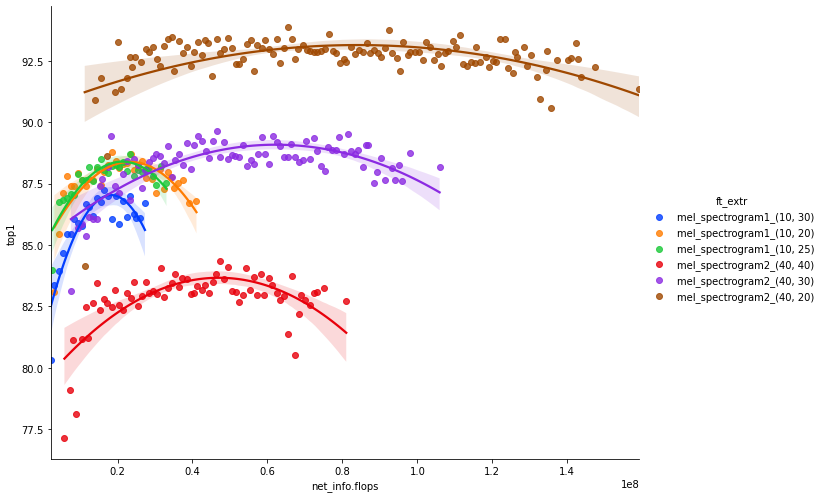

In [45]:
top_mel_df = remove_worse(mel_df, x, y, hue, flops_base)
# top_mel_df = top_mel_df[top_mel_df[x] < 3e7]

sns.lmplot(x=x, y=y, hue=hue, data=top_mel_df ,palette="bright", scatter=True, fit_reg=True, order = 2, height=height, aspect=aspect);

In [ ]:
top_df = remove_worse

In [ ]:
flops_base = 1000000
df_2 = remove_worse(df, x, y, hue, flops_base)
df_2 = df_2[df_2['net_info.flops']<1e8]

df_3 = df[df['net_info.flops']<1e8]

In [ ]:
g = sns.FacetGrid(df_2, col=hue, height=height, aspect=aspect)
g.map(sns.regplot, x, y, scatter=True, fit_reg=True, order = 2)


In [ ]:
sns.lmplot(x=x, y=y, hue=hue, data=df_2 ,palette="deep", scatter=True, fit_reg=True, order = 2, height=height, aspect=aspect);

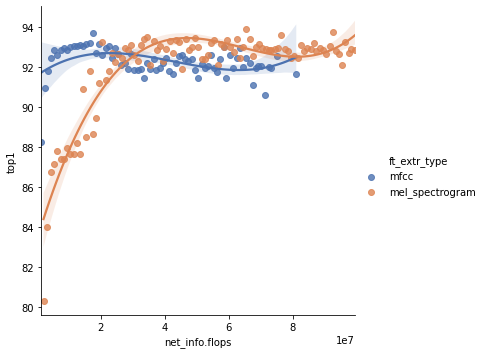

In [58]:
sns.lmplot(x=x, y=y, hue=hue, data=df_2, palette="deep", scatter=True, fit_reg=True, order=3);

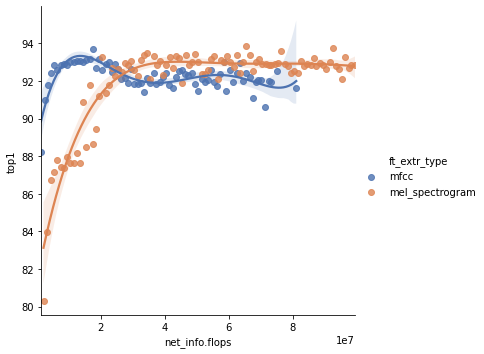

In [48]:
sns.lmplot(x=x, y=y, hue=hue, data=df_2, palette="deep", order = 5);

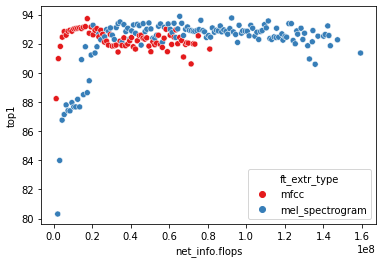

In [36]:
sns.scatterplot(x=x, y=y, hue=hue, data=df_2, markers=["o", "x"], palette="Set1");

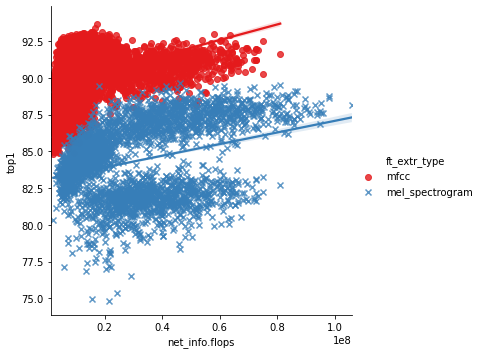

In [23]:
sns.lmplot(x=x, y=y, hue=hue, data=df2, markers=["o", "x"], palette="Set1");

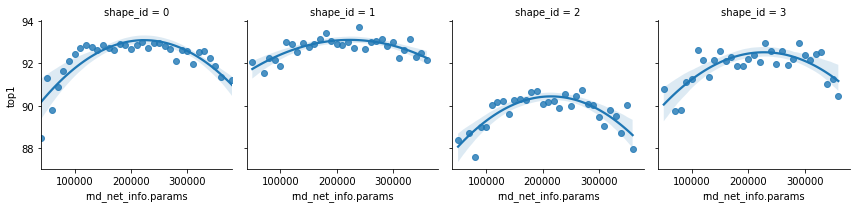

In [37]:
remove_worse_and_plot(df, 'net_info.params', 'top1', base=params_base)

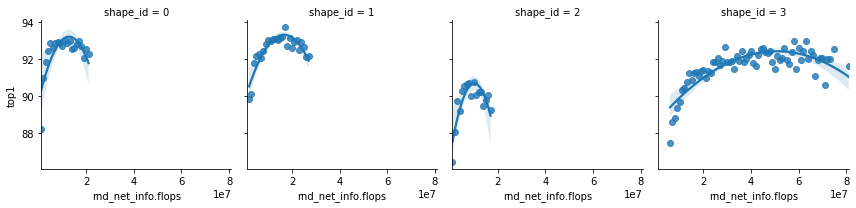

In [38]:
remove_worse_and_plot(df, 'net_info.flops', 'top1', base=flops_base)

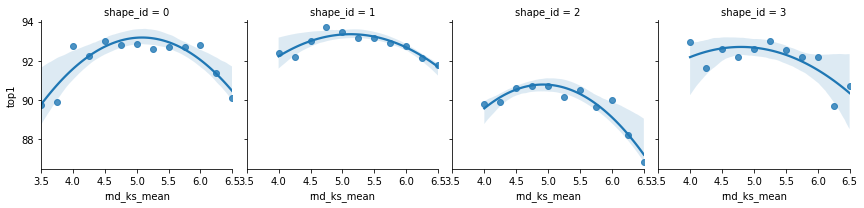

In [39]:
remove_worse_and_plot(df, 'ks_mean', 'top1', base=ks_base)

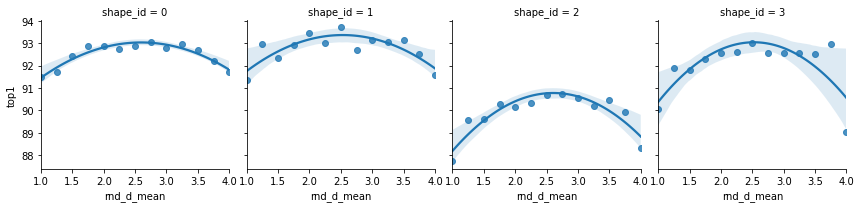

In [45]:
remove_worse_and_plot(df, 'd_mean', 'top1', base=d_base)

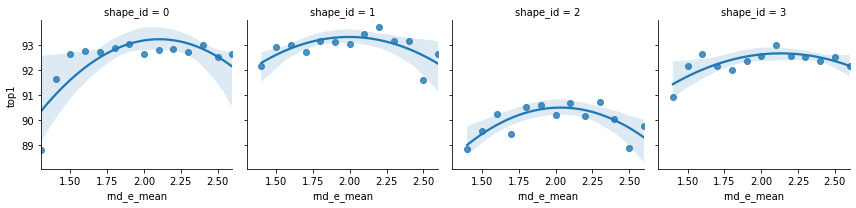

In [46]:
remove_worse_and_plot(df, 'e_mean', 'top1', base=e_base)

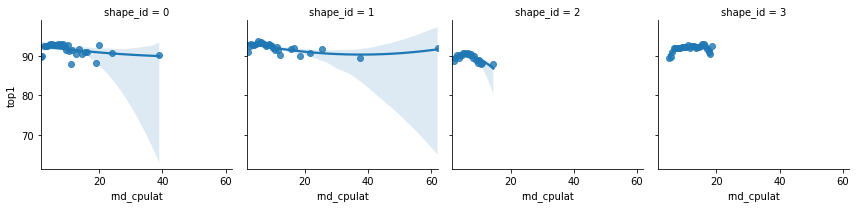

In [47]:
remove_worse_and_plot(df, 'cpulat', 'top1', base=oth_base)

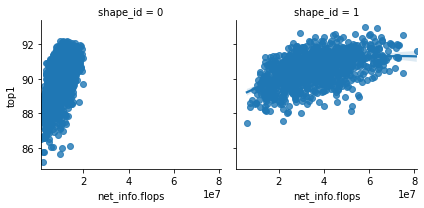

In [18]:
# sns.scatterplot(x="net_info.flops", y="top1", data=df, hue="params_id")
col = "shape_id" #"params_id"

g = sns.FacetGrid(temp_df, col=col)
g.map(sns.regplot, "net_info.flops", "top1", order=2)

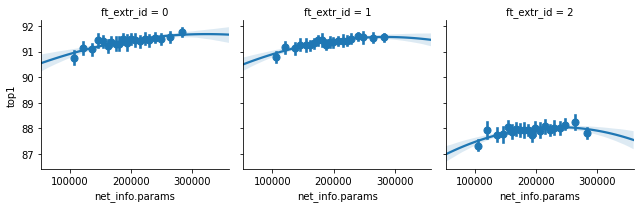

In [123]:
g = sns.FacetGrid(temp_df, col=col)
g.map(sns.regplot, "net_info.params", "top1", x_bins=20, order=2)

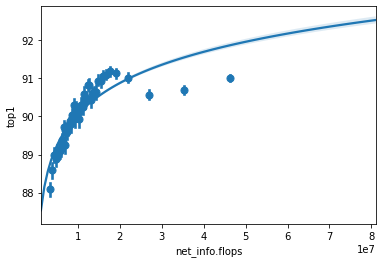

In [86]:
splot = sns.regplot(x="net_info.flops", y="top1", data=temp_df, x_estimator=np.mean, logx=True, x_bins=50) # order =2

<AxesSubplot:xlabel='net_info.params', ylabel='top1'>

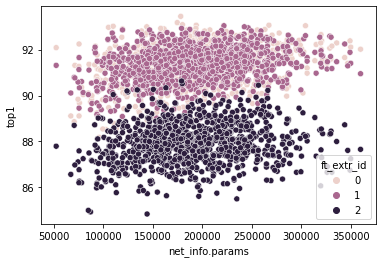

In [109]:
sns.scatterplot(x="net_info.params", y="top1", data=df, hue="ft_extr_id")

[[40, 40], [10, 30], [10, 40], [10, 50], [40, 30], [40, 40], [40, 50], [80, 30], [80, 40], [80, 50], [40, 40]]


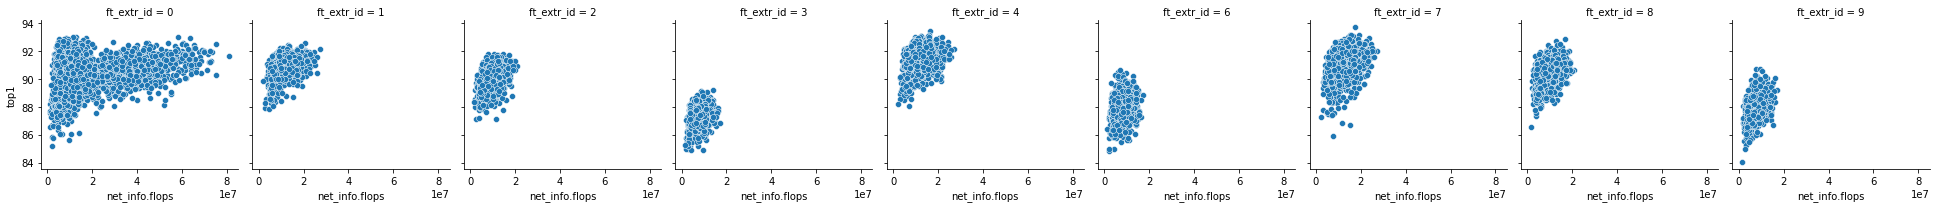

In [88]:
print(full_ft_extr_params_list)
g = sns.FacetGrid(df, col="ft_extr_id")
g.map(sns.scatterplot, "net_info.flops", "top1")

<AxesSubplot:xlabel='e_mean', ylabel='top1'>

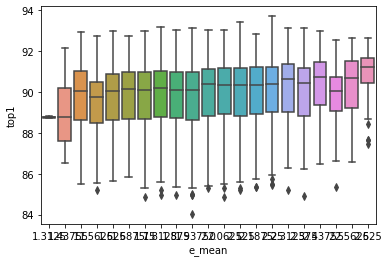

In [8]:
sns.boxplot(x="e_mean", y="top1", data=df)

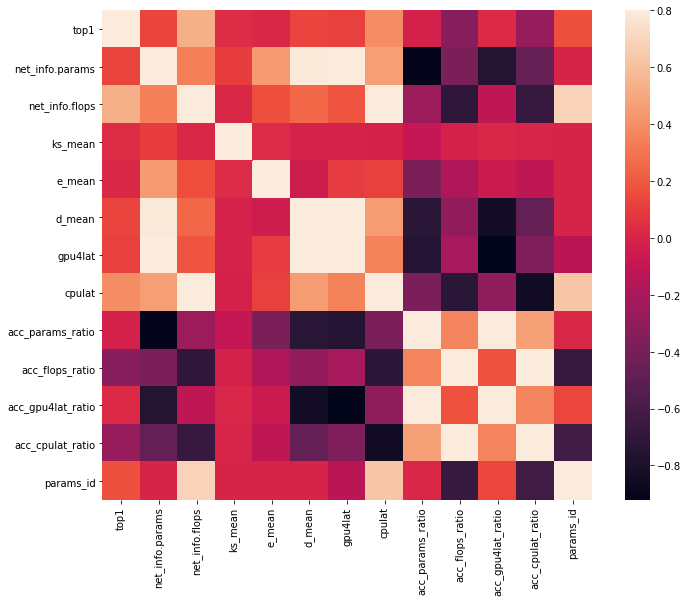

In [7]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

/Users/nielsescarfail/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


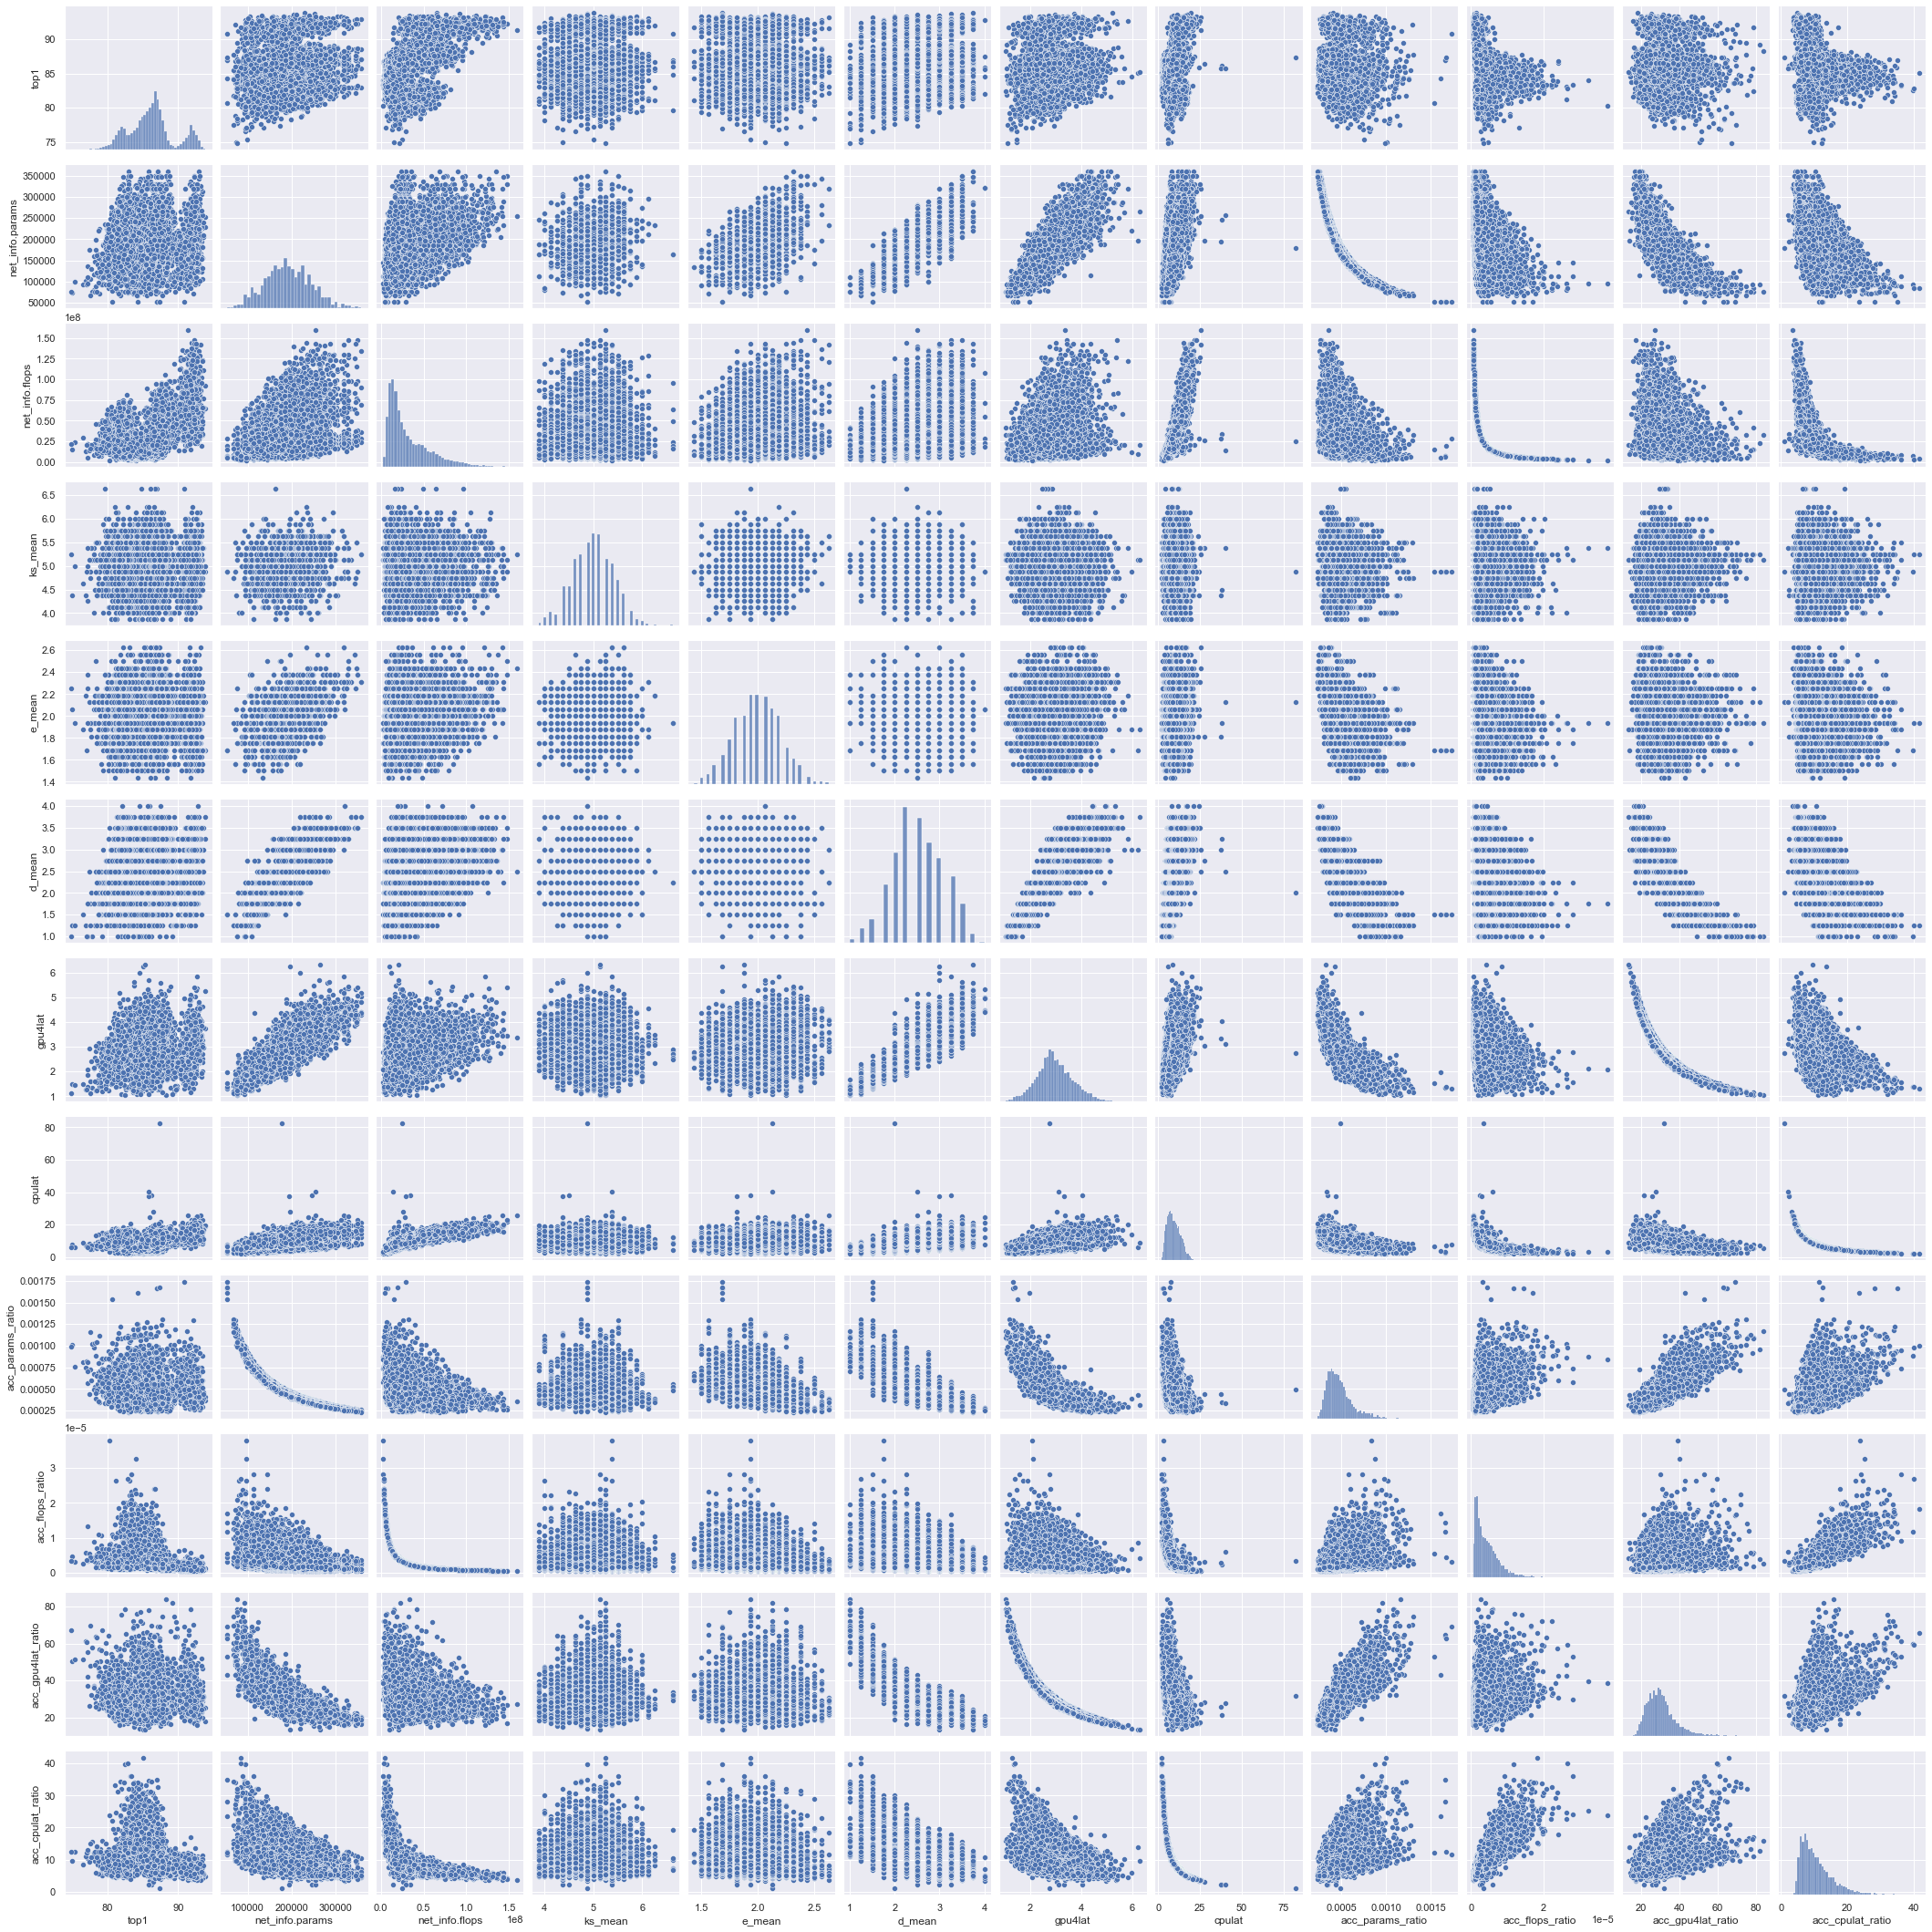

In [8]:
#scatterplot
sns.set()
cols = ['top1', 'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean',
       'd_mean', 'gpu4lat', 'cpulat', 'acc_params_ratio', 'acc_flops_ratio',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [9]:
df2 = df
df = df2
df.columns

Index(['w', 'ks', 'd', 'e', 'ft_extr_params', 'ft_extr_params', 'data_shape',
       'top1', 'net_info.params', 'net_info.flops', 'ks_mean', 'e_mean',
       'd_mean', 'gpu4lat', 'cpulat', 'acc_params_ratio', 'acc_flops_ratio',
       'acc_gpu4lat_ratio', 'acc_cpulat_ratio', 'params_id'],
      dtype='object')

In [12]:
df['cpulatr'] = df['cpulat'].apply(lambda x: round(x,1))

df_topcpu = df.groupby('cpulatr')['top1'].max()
# df['cpu'] = df.groupby('cpulatr')['top1'].max()
df_topcpu = pd.DataFrame(df_topcpu)
df_topcpu = df_topcpu.reset_index(level=0)
df_topcpu

cpulatr       top1
0        2.0  85.027226
1        2.1  82.849368
2        2.3  83.393831
3        2.4  82.259533
4        2.5  86.955539
..       ...        ...
201     27.8  86.456444
202     37.5  85.775865
203     38.2  86.206901
204     40.1  85.753175
205     82.3  87.318516

[206 rows x 2 columns]

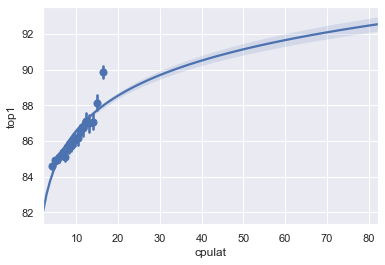

In [16]:
y = 'top1' 
x = 'cpulat'
splot = sns.regplot(x=x, y=y, data=df, logx=True, x_bins=20) # order =2

In [17]:
df_1 = df[df['params_id'] == 1]
df_2 = df[df['params_id'] == 2]

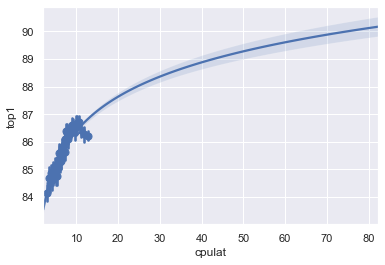

In [18]:
splot = sns.regplot(x=x, y=y, data=df_1, x_estimator=np.mean, logx=True, x_bins=50) # order =2


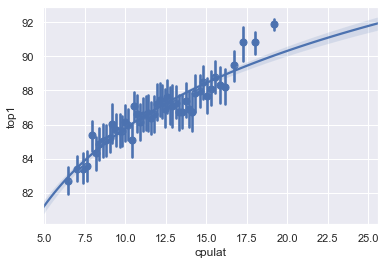

In [19]:
splot = sns.regplot(x=x, y=y, data=df_2, x_estimator=np.mean, logx=True, x_bins=50) # order =2


In [30]:
# new df from the column of lists
split_df = pd.DataFrame(df['ks'].tolist())
# display the resulting df
split_df

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
0      3   3   3   3   3   3   3   3   7   7   3   3   3   3   7   5
1      3   3   3   3   3   3   3   5   7   5   7   7   5   3   5   7
2      3   3   3   3   3   3   3   7   5   5   5   7   5   3   5   3
3      3   3   3   3   3   3   5   3   3   3   7   3   5   5   3   3
4      3   3   3   3   3   3   5   3   5   5   5   7   3   5   3   5
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
1375   3   5   3   7   5   3   3   3   7   7   7   3   3   7   3   7
1376   3   5   3   7   5   3   3   5   3   3   3   7   3   5   3   7
1377   3   5   3   7   5   3   3   5   3   7   5   5   3   7   7   7
1378   3   5   3   7   5   3   3   5   5   3   5   3   3   7   7   3
1379   3   5   3   7   5   3   3   5   7   5   7   3   3   3   3   7

[1380 rows x 16 columns]

In [19]:
df['top1'].mean()

89.81433759674431